In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from timeit import default_timer as timer 
from datetime import datetime
from tqdm import tqdm

In [3]:
import os, glob, pickle 

In [4]:
import skimage
#from skimage import img_as_float 
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd

In [6]:
import torch 


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
np.random.seed(9999)
import string 

In [9]:
class ZSerializableMixin:    ##TODO: at multiple inheritance/decorator MIXIN e.g. @ZRecord        
    data = None
    
    def load(self, fpath):
        with open(fpath, 'rb') as fd:
            self.data = pickle.load(fd)
    
    def save(self, fpath):
        with open(fpath, 'wb') as fd:
            pickle.dump(self.data, fd)


class FundusImageRemapMixin:
    remapped_data = None 
    
    def remap_fundus_img(self):    
        # 1a. resize image 
        self.data = self.resize_image(self.data)
        # 1b. rescale and retype
        self.data = self.image_rescale_retype(self.data)
        # 2. equalize 
        self.data = self.equalize_image(self.data) 
        #print(f"resized, rescaled, equalized: {self.data.shape}", end=", ")
        
        self.remapped_data = []
        # 3. vessels map << run on green Vs gray
        self.remapped_data.append( self.vessels_map_image(self.green) )  
        #print(f"vessels mapped", end=", ")
        # 4. color maps: green-details, red-intensity, blue-texture
        self.remapped_data.append( self.green_channel_update(self.green) )
        self.remapped_data.append( self.red_channel_update(self.red) )
        self.remapped_data.append( self.blue_channel_update(self.blue) )
        #print(f"colors mapped", end=", ") 

        # 5. combine and save << combine color maps separately first 
        outiez = self.combine_channelz(list(self.remapped_data[1:]))
        self.remapped_data.append( outiez )  
        # 5b.
        #self.save_fmap(fout, self.remapped_data )
        #print(f"combined and saved", end=", ")
    
    def image_rescale_retype(self, img):
        outiez = img.copy()
        outiez = outiez/255 ## assuming that's how they come in 
        outiez = skimage.img_as_float(outiez)
        return outiez
    
    def resize_image(self, img):
        return skimage.transform.rescale(img, 0.25, anti_aliasing=True) #im.resize_image((),) #img.copy() 
    
    def equalize_image(self, img):
        ## == TODO: choice at img traits 
        # a. adaptive histogram equalization update
        #outsiez = exposure.equalize_adapthist(img, clip_limit=0.03)
        # b. OR contrast stretching 
        p2, p98 = np.percentile(img, (2,98))
        outsiez = skimage.exposure.rescale_intensity(img, in_range=(p2,p98))        
        return outsiez
    
    def vessels_map_image(self, img):
        ## == TODO: tweak for performance 
        ## frangi vesselness << expects grayscale img 
        kwargs = {'sigmas': [1], 'mode': 'reflect', 'black_ridges': 0}
        outsiez = skimage.filters.frangi(img) #, **kwargs)        
        return outsiez 
    
    def green_channel_update(self, img):
        return img.copy()  
    
    def red_channel_update(self, img, thresh=0.97):
        outsiez = img.copy()
        red_range = outsiez.max() - outsiez.min()       
        outsiez[( (outsiez-outsiez.min())/red_range) < thresh] = 0   
        return outsiez        
    
    def blue_channel_update(self, img, thresh=1):
        outsiez = img.copy()
        outsiez[outsiez != 1] = 0         
        return outsiez
    
    def combine_channelz(self, cimagez):
        outsiez = np.dstack( cimagez)        
        return outsiez 
    
    ### === TODO: 
#     def explorer(self, num=None,):
        
#         def get_disease_code(self, fname):
#             return "TODO"

#         tx = ['vessels', 'green', 'red', 'blue', 'combo']
#         AnImage.plot_images_list(outsiez_prog+[-im for im in outsiez_prog], 
#                                  titlez=tx, 
#                                  nc=len(outsiez_prog), 
#                                  cmap='gray', 
#                                  save=f'{fname}_{self.get_disease_code(fname)}',
#                                  tdir=fprog,
#                                  withist=False)            
#         print("\n") 
        
        
#         fprog = f"{self.dir_output}/{self.dir_progress_maps}" ## DIR        
        
#         n = self.dataset_size   
#         if num is None:
#             samples = range(n)
#         else:      
#             samples = np.random.randint(0, n, size=num)
            
#         for i in samples:
#             try:
#                 ipath = self.dataset[i]
#                 fname = os.path.splitext( os.path.basename(ipath) )[0]

#                 print(f"{i}: Starting on {fname}", end=", ")
#                 # 1. get image from file 
#                 outsiez_prog = []
#                 anImg = AnImage(ipath)             
#                 # 2. equalize 
#                 anImg.image = self.equalize_image(anImg.image) 
#                 print(f"equalized", end=", ")
#                 outsiez_prog.append(anImg.green)
#                 outsiez_prog.append(anImg.red)
#                 outsiez_prog.append(anImg.blue)
#                 outsiez_prog.append( -self.red_channel_update(anImg.red) )
#                 outsiez_prog.append( -self.blue_channel_update(anImg.blue) )

#                 ### TODO: refactor, reuse 
#                 # 6. save progress imagez 
#                 def get_disease_code(fn):
#                     lbz = self.data_labelz[fn][0].split(" ")
#                     dlbl = []
#                     for l in lbz:
#                         d = self.disease_codez.get(l, None)
#                         if d:
#                             dlbl.append(d[1].strip())
#                     return "-".join(dlbl)


#                 tx = ['green', 'red', 'blue', 'r-update', 'b-update']
#                 AnImage.plot_images_list(outsiez_prog, #[-im for im in outsiez_prog], 
#                                          titlez=tx, 
#                                          nc=len(outsiez_prog), 
#                                          cmap='gray', 
#                                          save=f'histo_{fname}_{get_disease_code(fname)}',
#                                          tdir=fprog,
#                                          withist=True)            
#                 print("\n")
#             except:
#                 pass 
            
            
class ZModality(ZSerializableMixin):
    TYPE_GEN = 0
    TYPE_IMAGE = 1
    TYPE_TEXT = 2 
    
    def __init__(self, label, data=None, mod_type=TYPE_GEN):
        self.mod_type = mod_type
        self.label = label 
        self.data = data
        
    @property
    def size(self):
        return len(self.data) if self.data is not None else 0
    @property
    def stats(self):
        #mn = [int(chr(x)) for x in self.data]; mn = sum(mn)/len(mn)
        if (isinstance( self.data ,(np.ndarray, np.generic, list, tuple)) ):
            dmean = round(np.mean(self.data),3)
            dmin = round(np.min(self.data),3)
            dmax = round(np.max(self.data),3)
            dsize = self.data.shape if isinstance( self.data ,(np.ndarray, np.generic)) else len(self.data)
        else:
            dmean = 'N/A'
            dmin = min(self.data)
            dmax = max(self.data)
            dsize = len(self.data)
        return f"dtype={type(self.data)}, n={dsize}, min={dmin},  max={dmax},  mean={dmean}"
    
    def __repr__(self):
        return f"{self.__class__}: n={self.size}, data.dtype={type(self.data)}\n {self.__dict__}"
    
    
class ZImage(ZModality):     
    CLR_HSV = 0
    CLR_YUV = 1
    CLR_CIE = 2
    CLR_XYZ = 3 
    COLOR_SPACES = [skimage.color.rgb2hsv,
                   skimage.color.rgb2yuv,
                   skimage.color.rgb2rgbcie,
                   skimage.color.rgb2xyz,
                   ]
    
    def __init__(self, label, fpath, mod_type=ZModality.TYPE_IMAGE):
        super().__init__(label, mod_type=mod_type)
        self.fpath = fpath 
        self.data = skimage.io.imread( self.fpath ) 
        
    @property        
    def gray(self): 
        return skimage.color.rgb2gray( self.data )     
    @property
    def red(self):
        return self.get_channel(0)
    @property
    def green(self):
        return self.get_channel(1)
    @property
    def blue(self):
        return self.get_channel(2)    
    def get_channel(self, cid):
        c = len(self.data.shape)
        return self.data[:,:,cid] if c >=cid else None     
    def get_colorspace(self, cid):
        return ZImage.COLOR_SPACES[cid]( self.data )
       

class ZFundusImage(FundusImageRemapMixin, ZImage):     
    def __init__(self, label, fpath, mod_type=ZModality.TYPE_IMAGE):
        super().__init__(label, fpath, mod_type=mod_type) 
    

class ZRecord(ZSerializableMixin,list):
    #TODO: list of modality_elements    #ModalElements = list[ZModality], :<ZModality>
    ## TODO: serialize load/save self = data 
    def __init__(self, elements):
        super().__init__(elements)  
        self.data = self 
    ## TODO: self referencing in a list 
    def transform(self, scheme):
        return [m.data*10 for m in self.data]
        
        
class ZDataset(ZSerializableMixin):
    # TODO: A generator connected to some io object or list << can pd do this?? AND/OR batch loads for large files 
    #  pd dataframe to hold objects and do stats 
    #     pandas.DataFrame.transform
    #
    #  scikit @ shuffle, split, << sklearn.model_selection.train_test_split(array, pd, np, tensor??)
    #  scikit pipelines @ ETL transforms 
    #  
    def __init__(self, name='zdataset', durl=None, ):
        self.data = {'name':name, 'durl': durl} 
        self.dframe = pd.DataFrame() 
        self.train_mask = None
        self.test_mask = None
        self.validation_mask = None 
        
    
    #### ====== 0. Shuffle and split datasets into train-test-validate, batches, etc ======
    @property 
    def dataset(self): ## TODO: lazy loading from file 
        return self.dframe
        
    def train_test_validate_split(self, test_perc=0.3, validate_perc=0, shuffle=True):
        self.train_mask, self.test_mask = train_test_split(self.dframe, 
                                                        test_size=test_perc,
                                                        shuffle=shuffle,
                                                        random_state=999)
        print(f"Done splitting {test_perc}% test with shuffle = {shuffle}")
    
    
    #### ====== 1. Preprocessing transforms with sklearn pipelines and vectorizers ======
    
        
    #### ====== 2. Fetching Data from some resource or a local array ======
    def fetch_data(self, durl, has_header_row=True): ##TODO: refactor @ gen/mem mgt
        self.data['durl'] = durl 
        #self.storage = (r for r in open(durl, 'r')) ##This assumes line per record; would fail with pickled objects, for instance
        storage = []
        with open(durl, 'r') as fd:
            for rec in fd.readlines():
                storage.append( rec.strip().split('\t') )
       #         yield rec 
        self.set_data(storage) 
    
    ## Iteratively appending rows to a DataFrame can be more computationally intensive than a single concatenate. A better solution is to append those rows to a list and then concatenate the list with the original DataFrame all at once.
    def set_data(self, data, has_header_row=True, headers=None):
        if has_header_row:
            self.dframe = pd.DataFrame.from_records(data[1:], columns=data[0])
        else:
            self.dframe = pd.DataFrame.from_records(data, columns=headers)
       
    def glob_dir(self, durl, ext):
        self.data['durl'] = durl
        storage = []
        for f in sorted(glob.glob( f"{durl}/*.{ext}") ):
            fname = os.path.splitext( os.path.basename(f) )[0]
            img = skimage.io.imread( f )
            ishape = img.shape 
            imin, imax, imean, istd = img.min(), img.max(), img.mean(), img.std()
            storage.append([fname, f, ishape, imin, imax, imean, istd])
        headers = ['fname', 'fpath', 'ishape', 'imin', 'imax', 'imean', 'istd']
        self.set_data(storage, has_header_row=False, headers=headers)
    
    ## TODO: refactor + generalize 
    ## Pipeline = folder --> subsets --> file --> AnImage --> eq --> colormaps --> vessels --> save --> plot/report     
    def load_stare_fundus_dir(self, 
                              durl="../../data/stare_fundus", ext='ppm',
                              dcodes_txt="disease_codes.txt",
                              data_labelz_txt="all-mg-codes.txt"):
        
        disease_codez = {} #'7' :[ ['Background Diabetic Retinopathy', 'BDR-NPDR'], ]
        per_file_codez = {} #im0001 :['13 14', 'Choroidal Neovascularization AND Histoplasmosis'] 
        
        ## 0. disease code infor 
        def load_txt(fname, outds):
            with open(f"{durl}/{fname}", 'r') as fd:
                for f in fd.readlines():
                    rec = f.split("\t")  
                    outds[rec[0]] = [x.strip() for x in rec[1:] if len(x) > 0]
                    #yield rec 
        
                    
        load_txt(dcodes_txt,disease_codez)
        disease_one_hot = np.eye(len(disease_codez) )
        #print("one-hot shape: ", disease_one_hot.shape)
        
        #print(disease_codez)
        load_txt(data_labelz_txt,per_file_codez)
        
        def get_code(fname):
            rec = per_file_codez[fname]
            dcodez = [r for r in rec[0].strip().split(' ') if len(r) >0 and r.isnumeric() ]
            #print(rec)#,"\n",dcodez,"\n")
            dcodez_str = [disease_codez[i] for i in dcodez ] 
            #print(fname, dcodez,"===" ,dcodez_str)
            
            dcode_one_hot = np.zeros( len(disease_codez) )
            for d in dcodez:
                dcode_one_hot += disease_one_hot[int(d)]
            
            #print(dcode_one_hot, "---", list(dcode_one_hot))
            
            return( '++'.join([c for c in dcodez]), 
                    '++'.join([c[1] for c in dcodez_str] ),
                    '++'.join([c[0] for c in dcodez_str] ),
                    '++'.join(rec[-1:]),
                    list(dcode_one_hot) )
        
        
        ## 1. glob dir @ image files
        # self.glob_dir(fdir, ext) ## TODO: set fname as an index in dframe 
        self.data['durl'] = durl
        storage = []
        for f in sorted(glob.glob( f"{durl}/*.{ext}") ):
            fname = os.path.splitext( os.path.basename(f) )[0]
            img = skimage.io.imread( f )
            ishape = img.shape 
            imin, imax, imean, istd = img.min(), img.max(), img.mean(), img.std()
            
            dicode, dscode, ddcode, dnotes, dcode_one_hot = get_code(fname) 
            
            storage.append([fname, f, ishape, imin, imax, imean, istd, 
                            dicode, dscode, ddcode, dnotes]+dcode_one_hot)
            
            
        headerz = ['fname', 'fpath', 'ishape', 'imin', 'imax', 'imean', 'istd']        
        fheaderz = ['dcodez_id', 'dcodez_short', 'dcodez_desc', 'dnotes']
        dcode_one_hot_headerz = [r[1] for r in disease_codez.values() ]
        self.set_data(storage, has_header_row=False, headers=headerz+fheaderz+dcode_one_hot_headerz)
        
        
    def __repr__(self):
        return f"{self.data}\n{self.dframe.describe()}"
            
        
    

In [10]:
class ZUtilz:
    @staticmethod
    def plot_images_list(img_list, titlez=None, nc=2, cmap=None, 
                         save=None , tdir=".", savedpi=800, withist=False, binz=None):
       
        if withist:   
            n = len(img_list)*2
            nr = n//nc + ( 0 if n%nc == 0 else 1) 
        else:
            n = len(img_list)
            nr = n//nc + ( 0 if n%nc == 0 else 1) 
            
        ## image rows
        for i, img in enumerate(img_list):
            plt.subplot(nr, nc, (i+1) )
            plt.imshow( img, cmap=cmap)
            plt.axis('off')
            if titlez and (i<len(titlez)):
                plt.title( f"{titlez[i]}" ) #min(i, len(titlez)-1)
        
        ## histo rows 
        if withist:      
            for i, img in enumerate(img_list):
                plt.subplot(nr, nc, (i+1)+(n//2) )
                plt.hist(img.flatten()*(1/img.max()), bins=binz)
                plt.tick_params(axis='y', which='both', labelleft=False, labelright=False) #TODO:off
                
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if save:
            d = datetime.now().strftime("%H%M%S")
            plt.savefig(f"{tdir}/{d}_{save}.png", dpi=savedpi)
        
        plt.show();

In [11]:
t = ZModality('tester', 'The quick brown fox jumped over the lazy dogs')
t
print(t) #sum(t.data) )
t.stats

<class '__main__.ZModality'>: n=45, data.dtype=<class 'str'>
 {'mod_type': 0, 'label': 'tester', 'data': 'The quick brown fox jumped over the lazy dogs'}

<class '__main__.ZModality'>: n=45, data.dtype=<class 'str'>
 {'mod_type': 0, 'label': 'tester', 'data': 'The quick brown fox jumped over the lazy dogs'}


"dtype=<class 'str'>, n=45, min= ,  max=z,  mean=N/A"

"dtype=<class 'numpy.ndarray'>, n=(3200, 4800, 4), min=0,  max=255,  mean=221.821"

"dtype=<class 'numpy.ndarray'>, n=(3200, 4800, 4), min=0,  max=255,  mean=209.676"

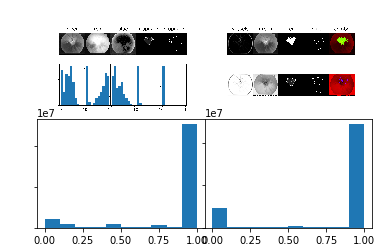

In [12]:
i1 = ZImage('tester-img', "t1.png")
i1.stats
i2 = ZImage('tester-img', "t2.png")
i2.stats
ZUtilz.plot_images_list([i1.data, i2.data], withist=True)

In [13]:
rec = ZRecord([t, i1])
print(type(rec))
#rec.data
#rec.mro()

[print(r.stats) for r in rec]
t.save('t.tx')
i1.save("t.im")

<class '__main__.ZRecord'>
dtype=<class 'str'>, n=45, min= ,  max=z,  mean=N/A
dtype=<class 'numpy.ndarray'>, n=(3200, 4800, 4), min=0,  max=255,  mean=221.821


[None, None]

In [14]:
rec.save("rec.ls")
l = ZRecord([])
l.load("rec.ls")
l = l.data
print(type(l))
[print(r.stats) for r in l]

<class '__main__.ZRecord'>
dtype=<class 'str'>, n=45, min= ,  max=z,  mean=N/A
dtype=<class 'numpy.ndarray'>, n=(3200, 4800, 4), min=0,  max=255,  mean=221.821


[None, None]

In [15]:
l2 = l.transform(None)
[print(r) for r in l2]

The quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogsThe quick brown fox jumped over the lazy dogs
[[[246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]
  ...
  [246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]]

 [[246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]
  ...
  [246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]]

 [[246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]
  ...
  [246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]]

 ...

 [[246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]
  ...
  [246 246 246 246]
  [246 246 246 246]
  [246 246 246 246]]

 [[246 246 246 246]
  [246 246 

[None, None]

In [16]:

ds = ZDataset(name='tester')
N = 10
idf = lambda x: ''.join(np.random.choice([c for c in string.ascii_uppercase + string.digits],size=x))
ll = {'idx': [idf(4) for _ in range(N)],
      'value': np.random.randint(100,250, size=N)}
#pd.DataFrame.from_records(ll)
ds.set_data(ll, has_header_row=False)
ds.dframe
ds.dframe.describe()

,idx,value
0,W2ZY,127
1,QM7F,220
2,76PU,237
3,MWI2,174
4,EOJK,106
5,T4DT,120
6,ZL7J,238
7,46T4,218
8,VZQ3,173
9,D61Z,190


,value
count,10.000000
mean,180.300000
std,49.132587
min,106.000000
25%,138.500000
50%,182.000000
75%,219.500000
max,238.000000


In [18]:
ds2 = ZDataset('rhymes', 'ds.txt')
ds2.fetch_data('ds.txt')
# _ = [print(r) for r in ds2.storage ] 
# ds2.storage 
ds2.dframe
ds2.dframe.describe()

,name,value,yaval,desc
0,cow,239,888,the cow on the moon
1,cat,348,12999,the cat with a fiddle beats puss in boots
2,spoon,23,7600,chasing the fork over the moon
3,man,1009,383,old man and mcdonald's farm


,name,value,yaval,desc
count,4,4,4,4
unique,4,4,4,4
top,man,239,12999,the cow on the moon
freq,1,1,1,1


In [19]:
ds3 = ZDataset()
ds3.glob_dir("../../data/stare_fundus", 'ppm')
ds3.dframe.describe()
ds3.dframe.head()

,imin,imax,imean,istd
count,397.000000,397.000000,397.000000,397.000000
mean,0.065491,253.967254,83.071825,73.856816
std,0.247703,6.358915,15.154158,13.368342
min,0.000000,179.000000,49.365399,31.962128
25%,0.000000,255.000000,72.793943,66.022203
50%,0.000000,255.000000,81.432149,76.270379
75%,0.000000,255.000000,92.292583,83.227167
max,1.000000,255.000000,178.768331,105.020058


,fname,fpath,ishape,imin,imax,imean,istd
0,im0001,../../data/stare_fundus/im0001.ppm,"(605, 700, 3)",0,255,72.884917,67.462580
1,im0002,../../data/stare_fundus/im0002.ppm,"(605, 700, 3)",0,255,72.075194,71.322069
2,im0003,../../data/stare_fundus/im0003.ppm,"(605, 700, 3)",0,255,88.611887,83.227167
3,im0004,../../data/stare_fundus/im0004.ppm,"(605, 700, 3)",0,255,77.254344,73.245229
4,im0005,../../data/stare_fundus/im0005.ppm,"(605, 700, 3)",0,255,102.024678,69.818867


In [20]:
ds4 = ZDataset()
ds4.load_stare_fundus_dir()
ds4.dframe.describe()
ds4.dframe.head()

,imin,imax,imean,istd,Normal,Emboli,BRAO,CRAO,BRVO,CRVO,Hemi-CRVO,BDR-NPDR,PDR,ASR,HTR,Coats,MA,CNV,UNDEF
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.065491,253.967254,83.071825,73.856816,0.098237,0.032746,0.017632,0.022670,0.027708,0.062972,0.030227,0.176322,0.057935,0.083123,0.090680,0.035264,0.020151,0.153652,0.400504
std,0.247703,6.358915,15.154158,13.368342,0.298010,0.178195,0.131777,0.149037,0.164341,0.243220,0.171427,0.381575,0.233914,0.276417,0.287516,0.184680,0.140694,0.361070,0.495739
min,0.000000,179.000000,49.365399,31.962128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,255.000000,72.793943,66.022203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,255.000000,81.432149,76.270379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,255.000000,92.292583,83.227167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,255.000000,178.768331,105.020058,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


,fname,fpath,ishape,imin,imax,imean,istd,dcodez_id,dcodez_short,dcodez_desc,...,CRVO,Hemi-CRVO,BDR-NPDR,PDR,ASR,HTR,Coats,MA,CNV,UNDEF
0,im0001,../../data/stare_fundus/im0001.ppm,"(605, 700, 3)",0,255,72.884917,67.462580,7,BDR-NPDR,Background Diabetic Retinopathy,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,im0002,../../data/stare_fundus/im0002.ppm,"(605, 700, 3)",0,255,72.075194,71.322069,13++9,CNV++ASR,Choroidal Neovascularization++Arteriosclerotic...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,im0003,../../data/stare_fundus/im0003.ppm,"(605, 700, 3)",0,255,88.611887,83.227167,14,UNDEF,Unknown Diagnosis,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,im0004,../../data/stare_fundus/im0004.ppm,"(605, 700, 3)",0,255,77.254344,73.245229,14++3,UNDEF++CRAO,Unknown Diagnosis++Cilio-Retinal Artery Occlusion,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,im0005,../../data/stare_fundus/im0005.ppm,"(605, 700, 3)",0,255,102.024678,69.818867,3++5,CRAO++CRVO,Cilio-Retinal Artery Occlusion++Central Retina...,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
ds4.dframe.iloc[4]['dnotes']

'Central Retinal Artery Occlusion AND Central Retinal Vein Occlusion'

In [22]:
ds4.dframe.sample(3).T

,44,142,363
fname,im0045,im0147,im0369
fpath,../../data/stare_fundus/im0045.ppm,../../data/stare_fundus/im0147.ppm,../../data/stare_fundus/im0369.ppm
ishape,"(605, 700, 3)","(605, 700, 3)","(605, 700, 3)"
imin,0,0,0
imax,255,255,255
imean,76.7141,96.1144,82.111
istd,78.4991,77.4048,81.261
dcodez_id,13++14++9,13++14,6
dcodez_short,CNV++UNDEF++ASR,CNV++UNDEF,Hemi-CRVO
dcodez_desc,Choroidal Neovascularization++Unknown Diagnosi...,Choroidal Neovascularization++Unknown Diagnosis,Hemi-Central Retinal Vein Occlusion


In [23]:
ds4.dframe['dcodez_short'].value_counts()

UNDEF                   90
BDR-NPDR                53
CNV++UNDEF              40
Normal                  36
PDR                     22
CRVO                    19
Coats                   14
HTR                     11
CNV                      9
Hemi-CRVO                9
BRVO                     8
BDR-NPDR++ASR            6
UNDEF++HTR               6
MA                       6
Emboli                   5
BDR-NPDR++UNDEF          5
ASR                      4
CNV++UNDEF++ASR          3
BDR-NPDR++HTR            3
CRAO++Emboli             3
BRVO++ASR                3
HTR++ASR                 3
BRAO++Emboli             3
HTR++BDR-NPDR            2
CRAO++CRVO               2
CRVO++ASR                2
UNDEF++ASR               2
BRAO++Emboli++ASR        2
CNV++UNDEF++HTR          2
BRAO                     2
CRVO++CRAO               2
CNV++HTR++UNDEF          2
Hemi-CRVO++ASR           2
Normal++UNDEF            2
CNV++UNDEF++UNDEF        1
MA++HTR++ASR             1
CRAO                     1
M

In [24]:
ds4.dframe.iloc[:, 11:].describe()

,Normal,Emboli,BRAO,CRAO,BRVO,CRVO,Hemi-CRVO,BDR-NPDR,PDR,ASR,HTR,Coats,MA,CNV,UNDEF
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.098237,0.032746,0.017632,0.022670,0.027708,0.062972,0.030227,0.176322,0.057935,0.083123,0.090680,0.035264,0.020151,0.153652,0.400504
std,0.298010,0.178195,0.131777,0.149037,0.164341,0.243220,0.171427,0.381575,0.233914,0.276417,0.287516,0.184680,0.140694,0.361070,0.495739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [25]:
ds4.train_test_validate_split()
len(ds4.train_mask)
len(ds4.test_mask)


Done splitting 0.3% test with shuffle = True


277

120

Normal       0.098237
Emboli       0.032746
BRAO         0.017632
CRAO         0.022670
BRVO         0.027708
CRVO         0.062972
Hemi-CRVO    0.030227
BDR-NPDR     0.176322
PDR          0.057935
ASR          0.083123
HTR          0.090680
Coats        0.035264
MA           0.020151
CNV          0.153652
UNDEF        0.400504
Name: mean, dtype: float64
<class 'pandas.core.series.Series'>


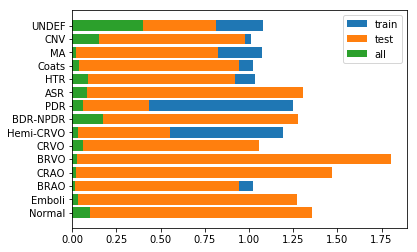

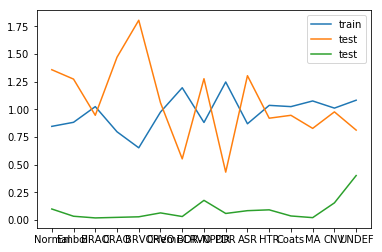

In [26]:
### TODO: plots 100% stacked proper normz
# plt.subplot(1,2,1)
# ds4.train_mask.iloc[:, 11:].describe().loc['mean'].plot('bar');
# plt.subplot(1,2,2)
# ds4.test_mask.iloc[:, 11:].describe().loc['mean'].plot('bar');

dfall = ds4.dframe.iloc[:,11:].describe().loc['mean']
print(dfall)
print(type(ds4.train_mask.iloc[:, 11:].describe().loc['mean']) )

dz = [ds4.train_mask.iloc[:, 11:].describe().loc['mean'], 
      ds4.test_mask.iloc[:, 11:].describe().loc['mean']]
lz = ['train', 'test']

for l, d in zip(lz, dz):    
    plt.barh( d.index, d.values/dfall.values, label=l)#, stacked=True)
plt.barh( dfall.index, dfall.values, label='all')
plt.legend()
plt.show();

plt.clf()
for l, d in zip(lz, dz):    
    plt.plot( d/dfall, label=l)#, stacked=True)    
plt.plot( dfall, label=l)
plt.legend()
plt.show();

# Clean Up

In [27]:
## 
import sklearn

In [28]:
class FuncParsers:    
    fpath_headerz = ['fname', 'fpath']    
    image_fpath_headerz = fpath_headerz + ['ishape', 'imin', 'imax', 'imean', 'istd']
    
    @staticmethod
    def fpath_parser(fpath):        
        fname = os.path.splitext( os.path.basename(fpath) )[0]
        outiez = [fname, fpath] 
        return outiez
    @staticmethod
    def fpath_with_idx_parser(fpath):        
        outiez = FuncParsers.fpath_parser(fpath)
        return outiez[0], outiez[1:]
    @staticmethod
    def fpath_images_parser(fpath):
        outiez = FuncParsers.fpath_parser(fpath)
        img = skimage.io.imread(fpath)
        outiez.append( img.shape ) 
        outiez.append( img.min() ) 
        outiez.append( img.max() ) 
        outiez.append( img.mean() ) 
        outiez.append( img.std() )
        return outiez 
    
    @staticmethod
    def file_line_parser(line, sep='\t'):
        outiez = line.strip().split(sep)
        return [x.strip() for x in outiez if len(x) > 0] ##TODO: clean up paranoia 
    @staticmethod
    def file_indexed_line_parser(line, sep='\t'):
        outiez = FuncParsers.file_line_parser(line, sep)
        return outiez[0], outiez[1:]
    
    @staticmethod     
    def stare_fundus_fpath_image_parser(fpath):
        pass
        
class SerializableMixin:
    data = None
    def load(self, fpath):
        with open(fpath, 'rb') as fb:
            self.data = pickle.load(fb) 
    def save(self, fpath):
        with open(fpath, 'wb') as fb:
            pickle.dump( self.data, fb)
            

            
class PdDataStats(SerializableMixin):
    def __init__(self):
        self.dframe = None 
        self.data = {'name':'pd_from_list_obj'}
        self.train_set = None
        self.test_set = None 
        
        
    ### ==== loading file data @? generator ==== 
    @property
    def size(self):
        return self.dframe.size if self.dframe is not None else 0 
    
    ## TODO: clean up 
    @property
    def file_content(self, fpath_col='fpath', vcolz=['fname', 'dcode']): ## TODO: make useful??,
        #return (f for f in self.select_colz_by_name(vcolz))
        #print("Working Colz: ", [fpath_col,]+vcolz  )
        for _,fp in self.select_colz_by_name( [fpath_col,]+vcolz ).iterrows():
            #print(fp)#, "\n", dir(fp)) ## TODO: refactor idz
            lbl = fp['fname']
            yield ZRecord( [ ZFundusImage( lbl, fp[fpath_col] ), ## TODO: ZImage refactor generic
                             ZModality( lbl, list(fp[vcolz]) ) ] )
    
     
    
    def train_test_validate_split(self, test_perc=0.3, validate_perc=0, shuffle=True):
        self.train_set, self.test_set = train_test_split(self.dframe, 
                                                        test_size=test_perc,
                                                        shuffle=shuffle,
                                                        random_state=999)
        print(f"Done splitting {test_perc}% test with shuffle = {shuffle}")
    
    
    ### ==== loading into pd-frame ====
    def load_list(self, itemz, headerz):
        self.dframe = pd.DataFrame.from_records(itemz, columns=headerz)
    
    def load_file(self, fpath, headerz, parser=FuncParsers.file_line_parser):
        itemz = []
        with open(fpath, 'r') as fd:
            for row in fd.readlines():
                itemz.append( parser(row) )
        self.load_list(itemz, headerz)
        #print( f"Loaded {fpath}: ",len(self.dframe))
        
    
    def load_dir(self, durl, ext,  breaker=None,
                 headerz=FuncParsers.fpath_headerz, 
                 parser=FuncParsers.fpath_parser):
        itemz = []
        for i, fp in enumerate( sorted(glob.glob( f"{durl}/*.{ext}") ) ): 
            itemz.append( parser(fp)  )
            if breaker and (i+1) >= breaker:
                break
        self.load_list(itemz, headerz) 
        
    ## TODO: refactor 
    def load_stare_fundus_dir(self,
                              durl="../../data/stare_fundus", ext='ppm',
                              dcodes_txt="disease_codes.txt",
                              data_labelz_txt="all-mg-codes.txt"):
        print(f"Loading fundus dir: {durl}")
        disease_codez = {} #'7' :[ ['Background Diabetic Retinopathy', 'BDR-NPDR'], ]
        per_file_codez = {} #im0001 :['13 14', 'Choroidal Neovascularization AND Histoplasmosis'] 
        
        ## 0. disease code infor 
        def load_txt(fname, outds):
            with open(f"{durl}/{fname}", 'r') as fd:
                for f in fd.readlines():
                    k, v = FuncParsers.file_indexed_line_parser(f)  
                    outds[k] = v 
                    #yield rec 
        
                    
        load_txt(dcodes_txt, disease_codez)
        disease_one_hot = np.eye(len(disease_codez) )
        print("one-hot shape: ", disease_one_hot.shape)
        
        #print(disease_codez)
        load_txt(data_labelz_txt, per_file_codez)
        
        def get_code(fname):
            rec = per_file_codez[fname]
            dcodez = [r for r in rec[0].strip().split(' ') if len(r) >0 and r.isnumeric() ]
            #print(rec)#,"\n",dcodez,"\n")
            dcodez_str = [disease_codez[i] for i in dcodez ] 
            #print(fname, dcodez,"===" ,dcodez_str)
            
            dcode_one_hot = np.zeros( len(disease_codez) )
            for d in dcodez:
                dcode_one_hot += disease_one_hot[int(d)]
            
            #print(dcode_one_hot, "---", list(dcode_one_hot))
            
            return( '++'.join([c for c in dcodez]),  #idz
                    '++'.join([c[1] for c in dcodez_str] ), #scodez
                    '++'.join([c[0] for c in dcodez_str] ), #desc
                    '++'.join(rec[-1:]), #notes
                    *list(dcode_one_hot) ) #onehotz
        
        def parser(x):
            outiez = FuncParsers.fpath_images_parser(x)
            outiez += get_code(outiez[0])
            return outiez 
        
        ## 1. glob dir @ image files  
        headerz=FuncParsers.image_fpath_headerz       
        fheaderz = ['dcodez_id', 'dcodez_short', 'dcodez_desc', 'dnotes']
        dcode_one_hot_headerz = [r[1] for r in disease_codez.values() ]
         
        self.load_dir(durl, ext, 
                      headerz=headerz+fheaderz+dcode_one_hot_headerz, 
                      parser=parser)
       
        
        
    ### ==== Stats and Visuals ====
    def select_colz_by_name(self, colz=None):
        return self.dframe.loc[:,colz] if colz is not None else self.dframe
    
    def summarize(self, colz=None, include='all'):
        return self.select_colz_by_name(colz).describe(include=include)
    
    ## TODO: seaborn etc 
    # kind = https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html 
    def visualize(self, colz=None, countz=False, plt_type='bar', **kwargz):
        if countz: ## TODO: refactor, generalize(dframe Vs dseries), Common charts menu 
            return self.dframe[colz].value_counts().plot(kind=plt_type, **kwargz)
        else:
            return self.select_colz_by_name(colz).plot(kind=plt_type, **kwargz) 
        

In [29]:
s = SerializableMixin()
s.data = ["The quick brown fox jumped over the lazy dogs", "The cat with a fiddle"]
s.data
s.data.append("And the cow jumped over the moon")
s.save('s.txt')

s2 = SerializableMixin()
s2.load('s.txt')
s2.data


['The quick brown fox jumped over the lazy dogs', 'The cat with a fiddle']

['The quick brown fox jumped over the lazy dogs',
 'The cat with a fiddle',
 'And the cow jumped over the moon']

In [30]:
durl="../../data/stare_fundus"
ext='ppm'
dcodes_txt="disease_codes.txt"
data_labelz_txt="all-mg-codes.txt"
disease_codez = {} #'7' :[ ['Background Diabetic Retinopathy', 'BDR-NPDR'], ]
per_file_codez = {} #im0001 :['13 14', 'Choroidal Neovascularization AND Histoplasmosis'] 
        
with open(f"{durl}/{dcodes_txt}", 'r') as fd:
    for f in fd.readlines():
        k, v = FuncParsers.file_indexed_line_parser(f) 
        disease_codez[k] = v
disease_codez

img_filez = []
for i, fp in enumerate( sorted(glob.glob( f"{durl}/*.{ext}") ) ): 
    img_filez.append( FuncParsers.fpath_images_parser(fp)  )
    if i >= 7:
        break
print(len(img_filez), ", ", str(img_filez[0]))

{'0': ['Normal/Healthy', 'Normal'],
 '1': ['Hollenhorst Emboli', 'Emboli'],
 '2': ['Branch Retinal Artery Occlusion', 'BRAO'],
 '3': ['Cilio-Retinal Artery Occlusion', 'CRAO'],
 '4': ['Branch Retinal Vein Occlusion', 'BRVO'],
 '5': ['Central Retinal Vein Occlusion', 'CRVO'],
 '6': ['Hemi-Central Retinal Vein Occlusion', 'Hemi-CRVO'],
 '7': ['Background Diabetic Retinopathy', 'BDR-NPDR'],
 '8': ['Proliferative Diabetic Retinopathy', 'PDR'],
 '9': ['Arteriosclerotic Retinopathy', 'ASR'],
 '10': ['Hypertensive Retinopathy', 'HTR'],
 '11': ["Coat's", 'Coats'],
 '12': ['Macroaneurism', 'MA'],
 '13': ['Choroidal Neovascularization', 'CNV'],
 '14': ['Unknown Diagnosis', 'UNDEF']}

8 ,  ['im0001', '../../data/stare_fundus/im0001.ppm', (605, 700, 3), 0, 255, 72.88491696182605, 67.4625795519138]


,imean,ishape,istd
count,8.000000,8,8.000000
unique,NaN,1,NaN
top,NaN,"(605, 700, 3)",NaN
freq,NaN,8,NaN
mean,79.751001,NaN,72.216130
std,10.522010,NaN,6.140042
min,71.473051,NaN,63.068499
25%,72.682486,NaN,69.229795
50%,76.476638,NaN,71.665081
75%,80.641728,NaN,74.328055


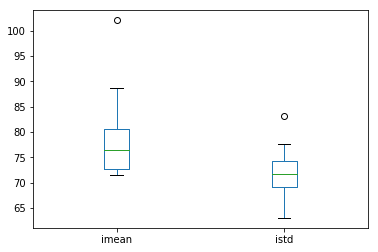

In [31]:
idf = PdDataStats()
idf.load_list(img_filez, headerz=FuncParsers.image_fpath_headerz)
idf.summarize(colz=['imean', 'ishape', 'istd'])

#idf.dframe.loc[:,['imean', 'istd']].plot('bar')
idf.visualize(colz=['imean', 'istd'], plt_type='box')

,idx,desc,scode,cases_n
count,15,15,15,15.000000
unique,15,15,15,NaN
top,9,Proliferative Diabetic Retinopathy,BRAO,NaN
freq,1,1,1,NaN
mean,NaN,NaN,NaN,756.866667
std,NaN,NaN,NaN,130.697506
min,NaN,NaN,NaN,525.000000
25%,NaN,NaN,NaN,664.500000
50%,NaN,NaN,NaN,773.000000
75%,NaN,NaN,NaN,868.000000


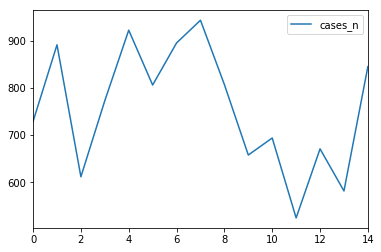

In [32]:
N = 1000
dheadz = ['idx', 'desc', 'scode', 'cases_n' ]  
def dparser(rec):
    return FuncParsers.file_line_parser(rec)+[ np.random.randint(N//2, N),]
idf1 = PdDataStats()
idf1.load_file(f"{durl}/{dcodes_txt}", headerz=dheadz, parser=dparser)
idf1.summarize()

#idf1.visualize(colz=['scode'], plt_type='barh')
#idf1.dframe['dcode'].plot(kind='barh')
idf1.visualize(colz=['cases_n',], plt_type='line')

,fname,fpath,ishape,imin,imax,imean,istd,dcode
count,10,10,10,10.000000,10.0,10.000000,10.000000,10
unique,10,10,1,NaN,NaN,NaN,NaN,2
top,im0004,../../data/stare_fundus/im0005.ppm,"(605, 700, 3)",NaN,NaN,NaN,NaN,NORMAL
freq,1,1,10,NaN,NaN,NaN,NaN,5
mean,NaN,NaN,NaN,0.300000,255.0,77.800255,70.356657,NaN
std,NaN,NaN,NaN,0.483046,0.0,10.825105,7.444511,NaN
min,NaN,NaN,NaN,0.000000,255.0,62.014763,55.969655,NaN
25%,NaN,NaN,NaN,0.000000,255.0,72.277625,68.051651,NaN
50%,NaN,NaN,NaN,0.000000,255.0,76.476638,70.594976,NaN
75%,NaN,NaN,NaN,0.750000,255.0,77.983701,72.935944,NaN


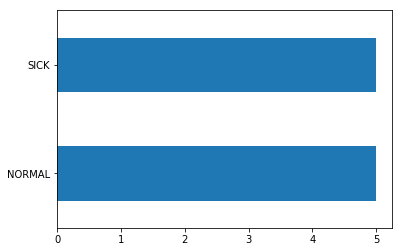

In [33]:
idf2 = PdDataStats()
idf2.load_dir(f"{durl}", 'ppm', breaker=10,
              headerz=FuncParsers.image_fpath_headerz+['dcode',], 
              parser=lambda x: FuncParsers.fpath_images_parser(x)+[np.random.choice(['NORMAL','SICK','UNDEF']),])
idf2.summarize()
idf2.visualize('dcode', plt_type='barh', countz=True, stacked=True)
#idf2.dframe['dcode'].value_counts().plot(kind='bar')

<generator object PdDataStats.file_content at 0x7fe1ceb0f318>

(605, 700, 3)
(605, 700, 3)
(605, 700, 3)


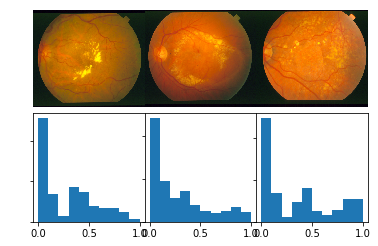

In [34]:
nmax = 3
imagez = []
idf2.file_content

imgz = []
for i, fp in enumerate(idf2.file_content):
#     print(type(fp) , len(fp))
#     _ = [print(type(r), ": ") for r in fp]
#     print(fp[0].data.shape)
    imgz.append( fp[0].data )
    if i >= 2:
        break
_ = [print(r.shape) for r in imgz]
ZUtilz.plot_images_list( imgz,  nc=len(imgz), withist=True)

Loading fundus dir: ../../data/stare_fundus
one-hot shape:  (15, 15)


,fname,fpath,ishape,imin,imax,imean,istd,dcodez_id,dcodez_short,dcodez_desc,...,CRVO,Hemi-CRVO,BDR-NPDR,PDR,ASR,HTR,Coats,MA,CNV,UNDEF
count,397,397,397,397.000000,397.000000,397.000000,397.000000,397,397,397,...,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
unique,397,397,1,NaN,NaN,NaN,NaN,48,48,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,im0130,../../data/stare_fundus/im0294.ppm,"(605, 700, 3)",NaN,NaN,NaN,NaN,14,UNDEF,Unknown Diagnosis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,397,NaN,NaN,NaN,NaN,90,90,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.065491,253.967254,83.071825,73.856816,NaN,NaN,NaN,...,0.062972,0.030227,0.176322,0.057935,0.083123,0.090680,0.035264,0.020151,0.153652,0.400504
std,NaN,NaN,NaN,0.247703,6.358915,15.154158,13.368342,NaN,NaN,NaN,...,0.243220,0.171427,0.381575,0.233914,0.276417,0.287516,0.184680,0.140694,0.361070,0.495739
min,NaN,NaN,NaN,0.000000,179.000000,49.365399,31.962128,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,255.000000,72.793943,66.022203,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,0.000000,255.000000,81.432149,76.270379,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,0.000000,255.000000,92.292583,83.227167,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


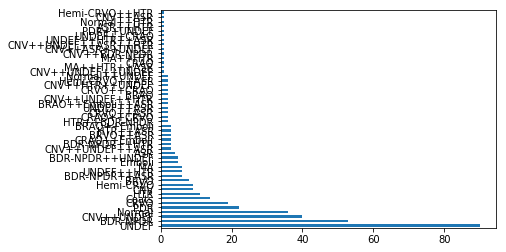

In [35]:
idf3 = PdDataStats()
idf3.load_stare_fundus_dir( )
idf3.summarize()
idf3.visualize('dcodez_short', plt_type='barh', countz=True, stacked=False)

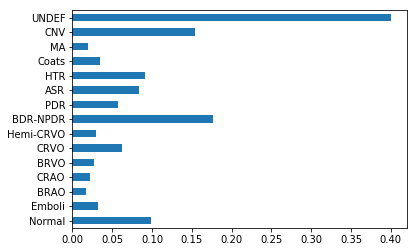

In [36]:
idf3.dframe.iloc[:, 11:].describe().loc['mean',:].plot(kind='barh');

In [37]:
nmax = 5
imagez = []

fund_imgz = []
for i, fp in enumerate(idf3.file_content): 
    ifp = fp[0] 
    print(type(ifp), ifp.data.shape)
    ifp.remap_fundus_img()
    print(len(ifp.remapped_data), ifp.remapped_data[0].shape ) 
    fund_imgz.append( ifp )
    if i >= nmax:
        break
print(len(fund_imgz))
_ = [print(type(r)) for r in fund_imgz]

<class '__main__.ZFundusImage'> (605, 700, 3)
5 (151, 175)
<class '__main__.ZFundusImage'> (605, 700, 3)
5 (151, 175)
<class '__main__.ZFundusImage'> (605, 700, 3)
5 (151, 175)
<class '__main__.ZFundusImage'> (605, 700, 3)
5 (151, 175)
<class '__main__.ZFundusImage'> (605, 700, 3)
5 (151, 175)
<class '__main__.ZFundusImage'> (605, 700, 3)
5 (151, 175)
6
<class '__main__.ZFundusImage'>
<class '__main__.ZFundusImage'>
<class '__main__.ZFundusImage'>
<class '__main__.ZFundusImage'>
<class '__main__.ZFundusImage'>
<class '__main__.ZFundusImage'>


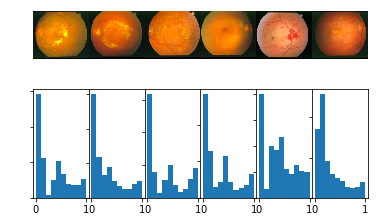

In [38]:

ZUtilz.plot_images_list( [f.data for f in fund_imgz],  nc=len(fund_imgz), withist=True)


<class 'list'> 3


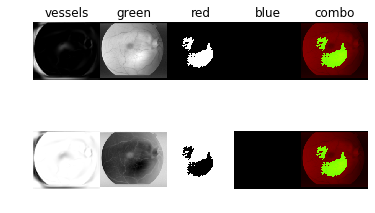

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


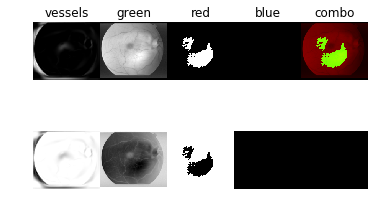

In [39]:
idx = np.random.randint(0,nmax)
print(type(fund_imgz[idx].remapped_data), idx)
remapz0 = fund_imgz[idx].remapped_data
tx = ['vessels', 'green', 'red', 'blue', 'combo'] ##TODO: recheck 'blue and combo'
ZUtilz.plot_images_list( remapz0+[-im for im in remapz0[:-1]]+[remapz0[-1]],  titlez=tx, 
                        nc=len(remapz0), withist=False, cmap='gray')

plt.clf()

ZUtilz.plot_images_list( remapz0+[-im for im in remapz0 ],  titlez=tx, 
                        nc=len(remapz0), withist=False, cmap='gray')
plt.show();

## Pipelines & NN.Module

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor  


from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [41]:
class LoadImageFileMixin:
    fpathcol = None
    healthycol = None
    undefcol = None
    
    def file_content(self, dframeX):
        for _,fp in dframeX.loc[:, ['fname',self.fpathcol, self.healthycol, self.undefcol] ].iterrows():
            #print(fp)#, "\n", dir(fp)) ## TODO: refactor idz 
            lbl = fp['fname']
            r = ZFundusImage( lbl, fp[self.fpathcol] ) ##TODO multimodality and fusion 
            r.remap_fundus_img()
            o = np.dstack( [r.remapped_data[0], r.remapped_data[-1]] )             
            #print( r.remapped_data[0].shape, " +++ ", r.remapped_data[-1].shape, " === ", o.shape)
            yield o

            
            
class StareFundusTransformer(LoadImageFileMixin, TransformerMixin, BaseEstimator):
    def __init__(self, fpathcol='fpath', healthycol='Normal', undefcol='UNDEF' ): 
        self.fpathcol = fpathcol
        self.healthycol = healthycol
        self.undefcol = undefcol
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        outiez = []
        for r in self.file_content(X): 
            outiez.append(r)
        return outiez 
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 :  5


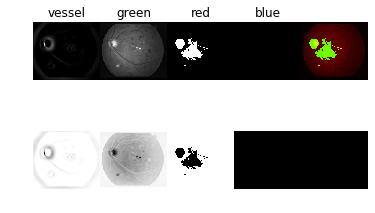

In [42]:
st = StareFundusTransformer()   
rez = st.transform(idf3.dframe.sample(4)) 
rez0 = rez[np.random.randint(0,4)]
remapz0 = [rez0[:,:,i] for i in range(rez0.shape[2])]
remapz0 += [ np.dstack(remapz0[1:])] 
tx = ['vessel', 'green', 'red', 'blue']
print(len(rez), ": ", len(remapz0))
ZUtilz.plot_images_list( remapz0+[-im for im in remapz0 ],  titlez=tx, 
                        nc=len(remapz0), withist=False, cmap='gray')

In [43]:
class Force2DTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #print('len: ', len(X))
        X_ = np.array(X).copy()
        #print("shape: ", X_.shape)
        oX_ = []
        for x in X_:
            w, h, c = x.shape 
            oX_.append( x.flatten() )#x.reshape(w*c, -1) )
        #print("oX.shape: ", oX_[0].shape, " for: ", len(oX_))
        return np.array(oX_)
    
piper = Pipeline([
    ('fundusor', StareFundusTransformer()),
    ('force2d', Force2DTransformer()),
    ('rescaler', StandardScaler())
])
piper.fit(idf3.dframe.sample(5))
Xrez = piper.transform( idf3.dframe.sample(5) )

print( len(Xrez), type(Xrez[0]))

Pipeline(memory=None,
     steps=[('fundusor', StareFundusTransformer(fpathcol='fpath', healthycol='Normal',
            undefcol='UNDEF')), ('force2d', Force2DTransformer()), ('rescaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

5 <class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 :  5


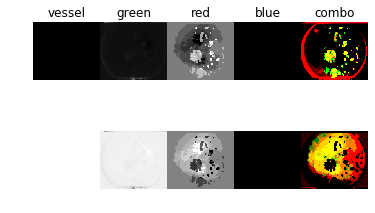

In [44]:
rez0 = Xrez[np.random.randint(0,5)].reshape((151, 175, -1))
remapz0 = [rez0[:,:,i] for i in range(rez0.shape[2])]
remapz0 += [ np.dstack(remapz0[1:])] 
tx = ['vessel', 'green', 'red', 'blue', 'combo']
print(len(rez), ": ", len(remapz0))
ZUtilz.plot_images_list( remapz0+[-im for im in remapz0 ],  titlez=tx, 
                        nc=len(remapz0), withist=False, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


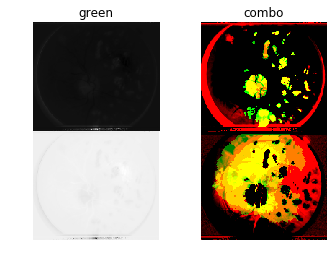

In [45]:
ig = [remapz0[1], remapz0[-1]]
ZUtilz.plot_images_list( ig+[-im for im in ig ],  titlez=['green','combo'], 
                        nc=len(ig), withist=False, cmap='gray', save="ttl.png", savedpi=1200)

In [46]:
class YLabelzFundusTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dscode='dscodez_short', healthycol='Normal', undefcol='UNDEF' ): 
        self.healthycol = healthycol
        self.undefcol = undefcol
        self.dscodez = dscode 
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['dclass'] = 'UNDEF' 
        X_['dclass_v'] = 0 
        X_.loc[ ( X_[self.healthycol] > 0 ), ['dclass']] = 'Normal' 
        X_.loc[ ( X_[self.healthycol] > 0 ), ['dclass_v']] = 1 
        X_.loc[ (X_[self.healthycol] <= 0) & (X_[self.undefcol] <= 0), ['dclass']] = 'Sick' 
        X_.loc[ (X_[self.healthycol] <= 0) & (X_[self.undefcol] <= 0), ['dclass_v']] = 2
        
#         X_['dclass'] = 'Not Sick' 
#         X_['dclass_v'] = 0  
#         X_.loc[ (X_[self.healthycol] != 1) & (X_[self.undefcol] != 1), ['dclass']] = 'Sick' 
#         X_.loc[ (X_[self.healthycol] != 1) & (X_[self.undefcol] != 1), ['dclass_v']] = 1
        #print(  )
        return X_
    
    
    def inverse_transform(self, X, y=None):
        return X.copy() 
       
class ForShowTargetTransformer(BaseEstimator, TransformerMixin):    
    def fit(self, X, y=None):
        return self
    
    def transform(self, y):
        return y.copy()
    
    
    def inverse_transform(self, y):
        return y.copy()
        

,fname,fpath,ishape,imin,imax,imean,istd,dcodez_id,dcodez_short,dcodez_desc,...,BDR-NPDR,PDR,ASR,HTR,Coats,MA,CNV,UNDEF,dclass,dclass_v
147,im0152,../../data/stare_fundus/im0152.ppm,"(605, 700, 3)",0,255,105.816010,78.011311,14,UNDEF,Unknown Diagnosis,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,UNDEF,0
203,im0209,../../data/stare_fundus/im0209.ppm,"(605, 700, 3)",0,255,90.249736,89.388430,4++9,BRVO++ASR,Branch Retinal Vein Occlusion++Arterioscleroti...,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sick,2
194,im0200,../../data/stare_fundus/im0200.ppm,"(605, 700, 3)",0,255,90.552449,96.284066,4,BRVO,Branch Retinal Vein Occlusion,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sick,2


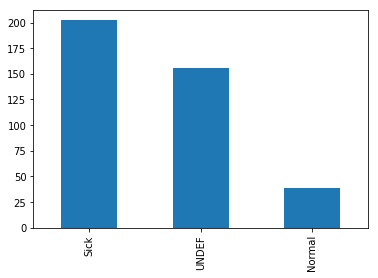

In [47]:
y_ = YLabelzFundusTransformer()
y_ = y_.transform(idf3.dframe ) #.sample(13)
y_.sample(3)
y_['dclass'].value_counts().plot(kind='bar')

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

idf3.train_test_validate_split()
y_ = YLabelzFundusTransformer()
y_train = y_.transform(idf3.train_set )['dclass_v'] 
y_test = y_.transform(idf3.test_set )['dclass_v']  

etrainX, etestX  = idf3.train_set,idf3.test_set

train_samples = len(idf3.train_set)

print(train_samples, y_train.size)

piper2 = Pipeline([
    ('fundusor', StareFundusTransformer()),
    ('force2d', Force2DTransformer()), ## flatten 
    ('rescaler', StandardScaler()),
    ('pca_dim', PCA(n_components=10) ), 
    ('logitor', LogisticRegression(C=50./train_samples, penalty='l1', 
                                   solver='saga', tol=0.0001, 
                                   multi_class='multinomial', 
                                   verbose=2, random_state=9))
])

model = TransformedTargetRegressor(
    regressor = piper2,
    transformer = ForShowTargetTransformer(),
    check_inverse = False )

model.get_params()

Done splitting 0.3% test with shuffle = True
277 277


{'check_inverse': False,
 'func': None,
 'inverse_func': None,
 'regressor__memory': None,
 'regressor__steps': [('fundusor',
   StareFundusTransformer(fpathcol='fpath', healthycol='Normal',
               undefcol='UNDEF')),
  ('force2d', Force2DTransformer()),
  ('rescaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca_dim',
   PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('logitor',
   LogisticRegression(C=0.18050541516245489, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='multinomial', n_jobs=None, penalty='l1',
             random_state=9, solver='saga', tol=0.0001, verbose=2,
             warm_start=False))],
 'regressor__fundusor': StareFundusTransformer(fpathcol='fpath', healthycol='Normal',
             undefcol='UNDEF'),
 'regressor__force2d': Force2DTransformer(),
 'regressor__rescaler': StandardSc

In [53]:
model.fit( idf3.train_set, y_train )
#dir(model)

#model.get_params()
logitor = model.get_params()['regressor__logitor'] 


max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


TransformedTargetRegressor(check_inverse=False, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('fundusor', StareFundusTransformer(fpathcol='fpath', healthycol='Normal',
            undefcol='UNDEF')), ('force2d', Force2DTransformer()), ('rescaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca_dim', PCA(copy=True, iterated_power='auto', n_components=10, random_state...='l1',
          random_state=9, solver='saga', tol=0.0001, verbose=2,
          warm_start=False))]),
              transformer=ForShowTargetTransformer())

In [54]:
logitor.__dict__

{'penalty': 'l1',
 'dual': False,
 'tol': 0.0001,
 'C': 0.18050541516245489,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': 9,
 'solver': 'saga',
 'max_iter': 100,
 'multi_class': 'multinomial',
 'verbose': 2,
 'warm_start': False,
 'n_jobs': None}

In [55]:

piper1 = Pipeline([
    ('fundusor', StareFundusTransformer()),
    ('force2d', Force2DTransformer()), ## flatten 
    ('rescaler', StandardScaler()),
    ('pca_dim', PCA(n_components=240) ), 
])
etrainX = piper1.fit_transform(idf3.train_set)
etestX = piper1.transform(idf3.test_set)


logitor = LogisticRegression(C=50./train_samples, penalty='l1', solver='saga', tol=0.00001, 
                             multi_class='multinomial', random_state=9,
                            verbose=5, max_iter=1500)

logitor.fit(etrainX, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


LogisticRegression(C=0.18050541516245489, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1500,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=9, solver='saga', tol=1e-05, verbose=5,
          warm_start=False)

In [56]:
#logitor.sparsify()
# print( type(logitor))
# print(dir(logitor))
sparsity = np.mean( logitor.coef_ == 0) * 100 
score = logitor.score(etestX, y_test)

print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
print("PCA reduction ratio: ", round(240/277, 4) ) 

Sparsity with L1 penalty: 28.47%
Test score with L1 penalty: 0.4250
PCA reduction ratio:  0.8664


(240,)


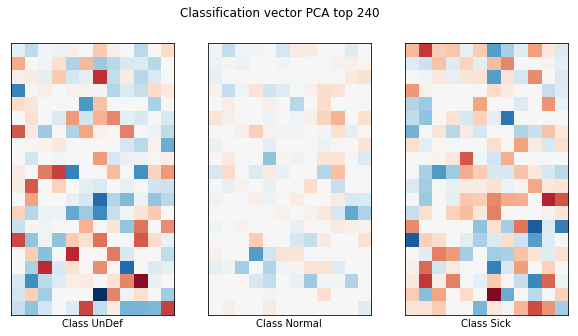

In [57]:
CLASS_LABELZ = ['UnDef', 'Normal', 'Sick']
COEF = logitor.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(COEF).max()
print( COEF[0].shape )
for i in range(3):
    try:
        cim = COEF[i].reshape((151, 175, -1))
        print(cim.shape )
        for c in [1,2,3]:
            ccm = 1/cim[:,:,c]*1 if c != 3 else cim[:,:,1:]/cim[:,:,:c]
            l1_plot = plt.subplot(3, 3, (i+1)+(3*(c-1)) ) 
            l1_plot.imshow(ccm, interpolation='nearest',
                           cmap=plt.cm.RdBu, vmin=-scale, vmax=scale) #
            l1_plot.set_xticks(())
            l1_plot.set_yticks(())
            l1_plot.set_xlabel(f'Class {CLASS_LABELZ[i]}' )
            
        plt.suptitle(f"Classification vector for channel {['green','red-update', 'combo']}")
    
    except: ##Forcing PCA case << TODO: Calc dims 
        cim = COEF[i].reshape((20, -1))
        ccm = cim
        l1_plot = plt.subplot(1, 3, (i+1) ) 
        l1_plot.imshow(ccm, interpolation='nearest',
                       cmap=plt.cm.RdBu, vmin=-scale, vmax=scale) #
        l1_plot.set_xticks(())
        l1_plot.set_yticks(())
        l1_plot.set_xlabel(f'Class {CLASS_LABELZ[i]}' )
        
        plt.suptitle(f"Classification vector PCA top {COEF[0].shape[0]}" )

# run_time = time.time() - t0
# print('Example run in %.3f s' % run_time)
plt.show();

In [58]:
print("===== No PCA =====")
piper1 = Pipeline([
    ('fundusor', StareFundusTransformer()),
    ('force2d', Force2DTransformer()), ## flatten 
    ('rescaler', StandardScaler()), 
])
etrainX = piper1.fit_transform(idf3.train_set)
etestX = piper1.transform(idf3.test_set)


logitor = LogisticRegression(C=50./train_samples, penalty='l1', solver='saga', tol=0.00001, 
                             multi_class='multinomial', random_state=9,
                            verbose=5, max_iter=1500)

logitor.fit(etrainX, y_train)

sparsity = np.mean( logitor.coef_ == 0) * 100 
score = logitor.score(etestX, y_test)

print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

===== No PCA =====


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1882 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.4min finished


LogisticRegression(C=0.18050541516245489, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1500,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=9, solver='saga', tol=1e-05, verbose=5,
          warm_start=False)

Sparsity with L1 penalty: 97.39%
Test score with L1 penalty: 0.4333


(105700,)
(151, 175, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(151, 175, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(151, 175, 4)


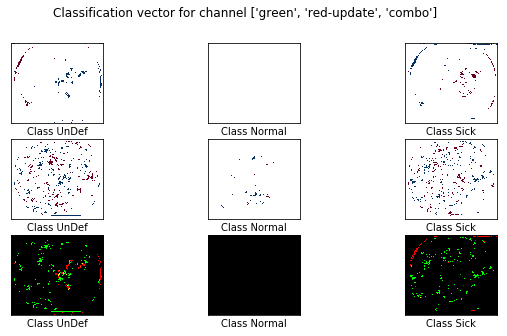

In [59]:
CLASS_LABELZ = ['UnDef', 'Normal', 'Sick']

COEF = logitor.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(COEF).max()
print( COEF[0].shape )
for i in range(3):
    cim = COEF[i].reshape((151, 175, -1))
    print(cim.shape )
    for c in [1,2,3]:
        ccm = 1/cim[:,:,c]*1 if c != 3 else cim[:,:,1:]/cim[:,:,:c]
        l1_plot = plt.subplot(3, 3, (i+1)+(3*(c-1)) ) 
        l1_plot.imshow(ccm, interpolation='nearest',
                       cmap=plt.cm.RdBu, vmin=-scale, vmax=scale) #
        l1_plot.set_xticks(())
        l1_plot.set_yticks(())
        l1_plot.set_xlabel( f'Class {CLASS_LABELZ[i]}' )

        
plt.suptitle(f"Classification vector for channel {['green','red-update', 'combo']}")

# run_time = time.time() - t0
# print('Example run in %.3f s' % run_time)
plt.show();

# Custom Models & Sklearn+PyTorch